<a href="https://colab.research.google.com/github/sbxrobotics/sbx-public/blob/main/SBX_Robotics_Mask_RCNN_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

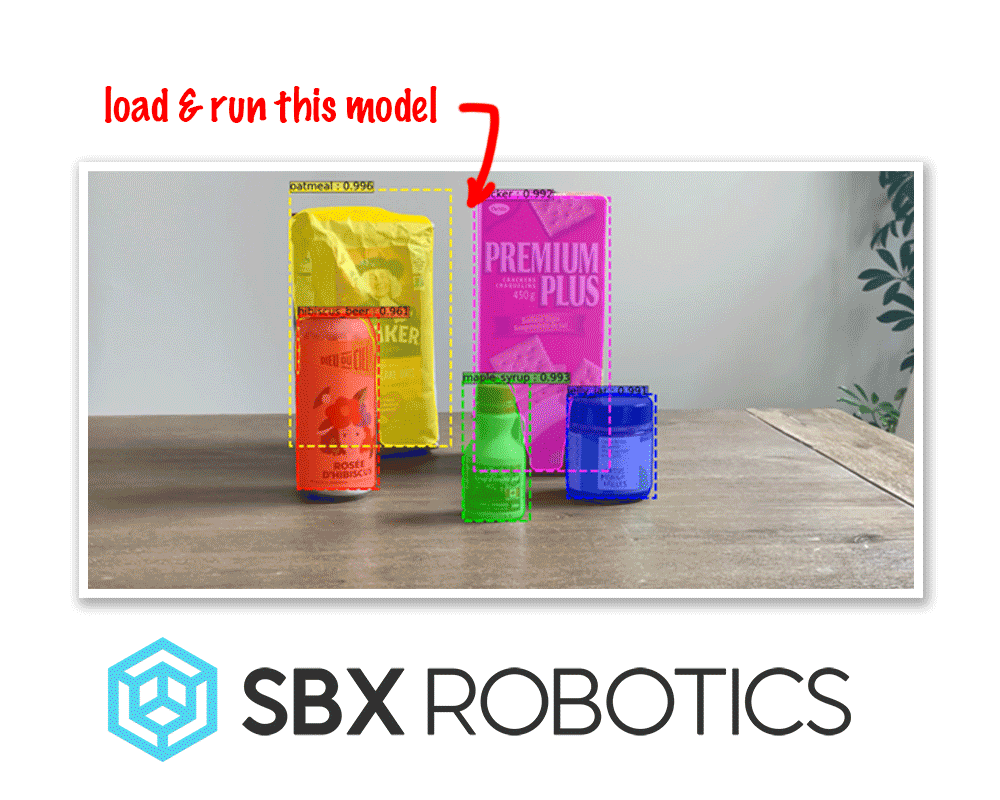

#Load and Evaluate a Mask R-CNN Model trained 100% on synthetic data

Synthetic training data is the fastest way to bootstrap and improve computer vision algorithms. 

Training on synthetic data produces robust deep learning models without data collection, labeling, and data cleaning.  

In this tutorial we'll load a model trained on 100% synthetic training data to demonstrate just how robust it can be.

# 1. Download Pre-trained SBX Model & Validation Images

We need to download few things before we get started:
- the pre-trained model
- a set of images to test it against

You can also download these resources locally from [sbxrobotics.com/get-started](https://sbxrobotics.com/get-started)

In [ ]:
!rm -rf sbx-kitchen-*
!wget https://sbx-sample-dataset.s3.us-east-2.amazonaws.com/sbx-kitchen/sbx-kitchen-model-18-05-2021.pth -q
!wget https://sbx-sample-dataset.s3.us-east-2.amazonaws.com/sbx-kitchen/sbx-kitchen-table-validation.tar.gz -q
!tar -xzf sbx-kitchen-table-validation.tar.gz
!ls sbx-kitchen*

#2. Define and Load Model 

In broad strokes we:

1.   Import some core libraries, including PyTorch and Torch Vision
2.   Parse a [COCO .json](https://cocodataset.org/#home) file to map model outputs to human-readable category labels *(e.g [1] -> 'oatmeal')*
3.   Initialize an "empty" MaskRCNN model from TorchVision
4.   Load our saved model weights into the empty model




In [ ]:
import glob
import json
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms.functional as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from pycocotools import mask as masktool


def get_cat_label_list_from_sbx_coco(coco_ds):
    """
    Returns a list of category label list from parsed COCO file: ['cat0', 'cat1', ..]
    """
    coco_cats = coco_ds["categories"]
    cats = sorted(coco_cats, key= lambda x : x["id"], reverse=False)
    cats = [x["name"] for x in cats]
    cats = list(set(cats))
    cats = sorted(cats,reverse=True)
    # ensure __background__ is first class
    cats = ['__background__'] + cats
    return cats


def get_model_instance_segmentation(num_classes):
    """
    Returns a segmentation model based on ResNet-50-FPN backbone with 
    re-initialized box_predictor and mask_predictor heads 
    """


    # load an instance segmentation model pre-trained on ResNet
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


# Load the COCO file that was used during model training, to map model outputs
# to sensible labels e.g ['__background__', 'oatmeal', 'maple_syrup', etc. ]
coco_data = json.load(open("./sbx-kitchen-table-validation/sbx-kitchen-table-coco.json"))
cat_labels = get_cat_label_list_from_sbx_coco(coco_data)
print(cat_labels)

# Instantiate a MaskRCNN model, and load the saved weights
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model = get_model_instance_segmentation(len(cat_labels))
model.load_state_dict(torch.load("./sbx-kitchen-model-18-05-2021.pth", map_location=device))
model.eval()
model.to(device)


#3. Evaluate Model

Now that our model has been loaded and mapped to the GPU we can run it on some images!

We will need to set up some image overlay tools:
- Generate a set of random colors of equal brightness
- Draw an outline mask over an image 

`show_inferences_on_image` is where the magic happens
- Run the model on the image, and save it into `outputs`
- Iterate through `outputs` and only draw the inferences above the confidence threshold
- draw `masks` as well as `boxes`, drawn from different "heads" of the model
- apply the appropriate label, based on the `cat_labels` mapping from the .JSON file earlier.  

In [ ]:
import colorsys
import random

from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """  Apply the given mask to the image.  """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def show_inferences_on_image(model, rgb_fname, cat_labels, colors, viz_threshold=0.7):
    """
    Evaluate `model` on the image in `fname` and show it with pyplot
    """

    # get the inferences out of the model
    with torch.no_grad():
      ten_rgb = transforms.to_tensor(Image.open(rgb_fname).convert("RGB"))
      outputs = model(torch.stack([ten_rgb]).to(device))

    # set up plotting + background image
    fig = plt.figure(dpi=100, figsize=(8.,5.))
    ax1 = fig.add_subplot(1,1,1)
    masked_image = np.array(Image.open(rgb_fname)).astype(np.uint32).copy()    
    
    # iterate through every output, and plot `masks` and `boxes`
    object_idx = -1
    masks = outputs[0]['masks']
    for box, score, label in zip(outputs[0]['boxes'], outputs[0]['scores'], outputs[0]['labels']):
      color = colors[label]
      object_idx += 1

      # only show infereneces above a 'confidence threshold'
      if score > viz_threshold:
        width = box[2]-box[0]
        height = box[3]-box[1]

        # plot the bounding box
        rect = patches.Rectangle((box[0],box[1]),width,height,
                                  linewidth=2,linestyle="dashed",
                                  edgecolor=color, facecolor='none')
        ax1.add_patch(rect)

        # apply the label
        class_name = cat_labels[label]

        # plot the mask overlay
        mask_np = np.array(masks[object_idx][0].cpu().numpy(),dtype=float)
        padded_mask = np.zeros(
            (mask_np.shape[0] + 2, mask_np.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask_np
        contours = find_contours(mask_np, 0.5)
        masked_image = apply_mask(masked_image, mask_np, color)

        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor=color, edgecolor=color, alpha=0.3)
          ax1.add_patch(p)

        ax1.text(box[0], box[1], "{} : {:.3f}".format(class_name, score), 
                 bbox=dict(facecolor=color, alpha=0.5, pad=0))

    ax1.imshow(masked_image.astype(np.uint8))
    ax1.set_title(rgb_fname.split("/")[-1])
    plt.show()


# run inference on a few test images
model.eval()
colors = random_colors(len(cat_labels))


# run inference on a few test images

show_inferences_on_image(model, './sbx-kitchen-table-validation/color/15.jpg', cat_labels, colors)
show_inferences_on_image(model, './sbx-kitchen-table-validation/color/10.jpg', cat_labels, colors)
show_inferences_on_image(model, './sbx-kitchen-table-validation/color/3.jpg', cat_labels, colors)


#run the inferences on all of the files in the test set
#rgb_fnames = glob.glob("./sbx-kitchen-table-validation/color/*.jpg")
#for rgb_fname in rgb_fnames:
#  show_inferences_on_image(model, rgb_fname, cat_labels, colors)


# Next steps

- Check out our [model training tutorial](https://)
- [Download the 10,000 image training dataset](https://) used to train this model. 



#### About SBX Robotics

We improve and boostrap computer vision systems using synthetic data. Clients submit 25 images from their production environment, and we generate 25,000 synthetic training samples benchmarked against the orginal 25. 

**Each SBX dataset ships with our best benchmark model**, just like the one used in this tutorial.